In [2]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')

# DB connection and path modification
import sys
import os

from scipy.sparse import load_npz

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/python")

# Algorithms
from implicit.nearest_neighbours import CosineRecommender # KNN Item Based
from implicit.cpu.lmf import LogisticMatrixFactorization # Matrix Factorization
from implicit.cpu.bpr import BayesianPersonalizedRanking # Model Based
    
from implicit_extend.popularity import PopularityRecommender, PopularityNumCommentsRecommender # Popularity
from implicit_extend.random import RandomRecommender # Random
from implicit_extend.nearest_neighbours_ub import CosineRecommenderUB # KNN User Based
from implicit_extend.content_based import ContentBasedRecommender  # Content Based
from implicit_extend.hybrid import HybridRecommenderUB, HybridRecommenderIB # Hybrids

from implicit_extend.evaluation import ranking_metrics_at_k # Ranking metrics calculator

# Auxiliary Functions
from dm_function_lib import read_table, get_rm_train_test_info, tunning_and_metrics, gen_recommendations, \
get_prop_tag_matrix

import matplotlib.pyplot as plt

In [3]:
MODEL_ORDER = {"rand":0, "pop": 1, "pop_nc":2,
               "ib": 3, "ub":4, "mf": 5, "bpr": 6,
               "cb_cat": 7, "cb_top": 8, "cb_loc":9,
               "cbib_cat":10, "cbib_top":11, "cbib_loc":12,
               "cbub_cat":13, "cbub_top":14, "cbub_loc":15}

In [4]:
rm, rm_train, rm_test = get_rm_train_test_info(c='c1')

In [5]:
# Item profiles for the different tags: categories, topics y districts
outdir = '../../data/tags/'
prop_cat = {'item_profiles': load_npz(outdir+"cat_item_profiles.npz").astype(float),
                'proposalId_cnv': pd.read_csv(outdir+"/cat_proposalId_cnv.csv", sep=";", encoding='utf-8'),
                'tagId_cnv': pd.read_csv(outdir+"/cat_tagId_cnv.csv", sep=";", encoding='utf-8')}
prop_top = {'item_profiles': load_npz(outdir+"top_item_profiles.npz").astype(float),
            'proposalId_cnv': pd.read_csv(outdir+"/top_proposalId_cnv.csv", sep=";", encoding='utf-8'),
            'tagId_cnv': pd.read_csv(outdir+"/top_tagId_cnv.csv", sep=";", encoding='utf-8')}
prop_loc = {'item_profiles': load_npz(outdir+"loc_item_profiles.npz").astype(float),
            'proposalId_cnv': pd.read_csv(outdir+"/loc_proposalId_cnv.csv", sep=";", encoding='utf-8'),
            'tagId_cnv': pd.read_csv(outdir+"/loc_tagId_cnv.csv", sep=";", encoding='utf-8')}

In [6]:
print("\tNum Users =", rm['rm'].shape[0])
print("\tNum Proposals =", rm['rm'].shape[1])
print("\tNum Comments =", sum(rm['rm'].data))
print("\tNum Commented Proposals / User =",len(rm['rm'].data)/rm['rm'].shape[0])
print("\tNum Commented Proposals / Proposal =",len(rm['rm'].data)/rm['rm'].shape[1])
print("\tNum Commented Proposals / (User x Proposal) =",
      len(rm['rm'].data)/(rm['rm'].shape[0]*rm['rm'].shape[1]))


	Num Users = 8009
	Num Proposals = 9677
	Num Comments = 34149
	Num Commented Proposals / User = 3.085778499188413
	Num Commented Proposals / Proposal = 2.5538906685956393
	Num Commented Proposals / (User x Proposal) = 0.00031887759627864144


In [7]:
# We define the cuttoff for the Hyperparameter Search (N=100), for the final rankings and metrics (Nf=50)
# and the number of Cross Validation Folds cvk=5
N=100
Nf=50
cvk=5

# Popularity Recommender

In [215]:
# 5-CV metrics
model={"pop": {'m':PopularityRecommender, 'params':{}}}
metric_results_pop, _, _, final_metrics_users_pop = \
    tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=model)
metric_results_pop

IntProgress(value=0, max=2491)

PopularityRecommender


,precision,recall,map,ndcg@100,auc,mrr,f1
pop,0.002806,0.194018,0.03344,0.067003,0.001445,0.042554,0.005319


In [216]:
# Final metrics
m = PopularityRecommender()
m.fit(rm_train)

final_metrics_pop = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                    index=['pop'])
final_metrics_pop

IntProgress(value=0, max=2491)

PopularityRecommender


,precision,recall,map,ndcg@50,auc,mrr,f1
pop,0.004279,0.154419,0.03283,0.059993,0.000533,0.041846,0.007931


In [217]:
# Save final recommendations
recs_pop = gen_recommendations(rm, rm_train, rm_test, model_name='pop', model=PopularityRecommender, save=True, c='', N=Nf)

# Popularity Num Comments Recommender

In [218]:
models={"pop_nc": {'m':PopularityNumCommentsRecommender, 'params':{}}}
metric_results_popnc, _, _, _ = tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=models)
metric_results_popnc

IntProgress(value=0, max=2491)

PopularityNumCommentsRecommender


,precision,recall,map,ndcg@100,auc,mrr,f1
pop_nc,0.002557,0.17653,0.022499,0.054835,0.001323,0.028889,0.004843


In [220]:
m = PopularityNumCommentsRecommender()
m.fit(rm_train)

final_metrics_pop_nc = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['pop_nc'])
final_metrics_pop_nc

IntProgress(value=0, max=2491)

PopularityNumCommentsRecommender


,precision,recall,map,ndcg@50,auc,mrr,f1
pop_nc,0.00395,0.142797,0.021988,0.048868,0.000491,0.02828,0.00734


In [221]:
recs_popnc = gen_recommendations(rm, rm_train, rm_test, model_name='pop_nc', model=PopularityNumCommentsRecommender,
                                 save=True, c='', N=Nf)

# Random Recommender

In [222]:
model={"rand": {'m':RandomRecommender, 'params':{}}}
metric_results_rand, _, _, final_metrics_users_rand = tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N,
                                                                          model=model)
metric_results_rand

IntProgress(value=0, max=2491)

RandomRecommender


,precision,recall,map,ndcg@100,auc,mrr,f1
rand,0.000217,0.01125,0.000261,0.002193,0.000042,0.000616,0.000364


In [223]:
m = RandomRecommender()
m.fit(rm_train)

final_metrics_rand = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['rand'])
final_metrics_rand

IntProgress(value=0, max=2491)

RandomRecommender


,precision,recall,map,ndcg@50,auc,mrr,f1
rand,0.000233,0.004252,0.000585,0.001448,0.00001,0.000904,0.000354


In [224]:
recs_rand_c1 = gen_recommendations(rm, rm_train, rm_test, model_name='rand', model=RandomRecommender, save=True, c='', N=Nf)


# Logistic Matrix Factorization para K factores

LogisticMatrixFactorization has a hyperparameter "factors":= number of factors if the factorization. Here we try different values to find which maximises the results.

In [225]:
model={"mf": {'m':LogisticMatrixFactorization,
               'params':{"factors": [i for i in range(5, 41, 5)]}}}

In [226]:
metric_results_mf, train_results_mf, test_results_mf, _ = \
    tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=model, check_overfitting=True)

Random Seeds [4193399054, 1336580701, 3041148831, 397972906, 3723851948]
mf5
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
mf10
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
mf15
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
mf20
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
mf25
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
mf30
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
mf35
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
mf40
Iter 1 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2109)

LogisticMatrixFactorization
Iter 2 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2071)

LogisticMatrixFactorization
Iter 3 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

LogisticMatrixFactorization
Iter 4 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2100)

LogisticMatrixFactorization
Iter 5 

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2098)

LogisticMatrixFactorization


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization
Best params are ->  {'factors': 5}


  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization


In [227]:
train_results_mf

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
mf5,0.001312,0.004754,0.034474,0.040747,0.065794,0.002472,0.184370,0.008184,0.124386
mf10,0.001148,0.003706,0.039200,0.044920,0.062425,0.001922,0.139103,0.010755,0.172284
mf15,0.000903,0.002904,0.037731,0.044692,0.054786,0.001508,0.104079,0.008865,0.161818
mf20,0.000726,0.002183,0.037569,0.044150,0.049584,0.001128,0.081819,0.008641,0.174264
mf25,0.000644,0.001888,0.035403,0.041942,0.045826,0.000977,0.072377,0.007223,0.157627
mf30,0.000613,0.001701,0.035357,0.041026,0.044552,0.000880,0.067973,0.008884,0.199414
mf35,0.000563,0.001633,0.034794,0.041023,0.043043,0.000844,0.062708,0.009071,0.210740
mf40,0.000602,0.001708,0.037537,0.044114,0.046189,0.000881,0.066817,0.012103,0.262026


In [228]:
test_results_mf

,precision,recall,map,ndcg@100,auc,mrr,f1
mf5,0.002152,0.142481,0.027524,0.053026,0.000740,0.033842,0.004078
mf10,0.001666,0.104135,0.030991,0.049017,0.000560,0.038253,0.003166
mf15,0.001285,0.078766,0.027397,0.040726,0.000415,0.034282,0.002424
mf20,0.001032,0.066373,0.026802,0.037373,0.000312,0.033047,0.001956
mf25,0.000871,0.059601,0.026466,0.035355,0.000274,0.032766,0.001650
mf30,0.000719,0.046060,0.022150,0.028951,0.000192,0.028629,0.001351
mf35,0.000626,0.041578,0.021647,0.027483,0.000192,0.027111,0.001181
mf40,0.000470,0.031962,0.019238,0.022969,0.000146,0.024375,0.000879


In [229]:
metric_results_mf

,precision,recall,map,ndcg@100,auc,mrr,f1
mf5,0.002296,0.161025,0.031488,0.058898,0.000926,0.038223,0.004367


### Result LogisticMatrixFactorization NDCG@100:
- factos=5

In [230]:
m = LogisticMatrixFactorization(factors=5)
m.fit(rm_train)

final_metrics_mf = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                index=['mf'])
final_metrics_mf

  0%|          | 0/30 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

LogisticMatrixFactorization


,precision,recall,map,ndcg@50,auc,mrr,f1
mf,0.003661,0.135062,0.026034,0.050099,0.000447,0.032346,0.006785


In [231]:
recs_mf = gen_recommendations(rm, rm_train, rm_test, model_name='mf', model=LogisticMatrixFactorization,
                              params={'factors':5}, save=True, c='', N=Nf)

  0%|          | 0/30 [00:00<?, ?it/s]

# Nearest Neighbours Item Based, Cosine Distance

For the CosineRecommender (KNN Item Based with Cosine Distance) we must find the the number of neighbours K that maximises NDCG@100

In [232]:
model={"ib": {'m':CosineRecommender,
               'params':{"K": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]}}}

In [233]:
metric_results_ib, train_results_ib, test_results_ib, _ = tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N,
                                                                              model=model, check_overfitting=True)

Random Seeds [2495628532, 2120645900, 246433673, 1002363487, 1550822253]
ib5
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib10
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib15
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib20
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib25
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib30
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib35
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib40
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib45
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib50
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib60
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib70
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib80
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
ib100
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2157)

CosineRecommender
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2097)

CosineRecommender
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2083)

CosineRecommender
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

CosineRecommender
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

CosineRecommender


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender
Best params are ->  {'K': 80}


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender


In [234]:
metric_results_ib

,precision,recall,map,ndcg@100,auc,mrr,f1
ib80,0.000715,0.034829,0.00623,0.012515,0.000177,0.009485,0.001238


In [235]:
train_results_ib.sort_values(by='ndcg@100', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
ib80,0.000144,0.001183,0.005464,0.007762,0.011377,0.000665,0.032750,0.000438,0.038485
ib70,0.000134,0.001145,0.005339,0.007786,0.011095,0.000642,0.031798,0.000463,0.041715
ib100,0.000153,0.001122,0.005453,0.007781,0.011071,0.000636,0.031183,0.000554,0.050047
ib60,0.000125,0.001130,0.005325,0.007670,0.010957,0.000632,0.030856,0.000657,0.059950
ib50,0.000115,0.001107,0.005298,0.007721,0.010795,0.000621,0.029993,0.000804,0.074440
ib45,0.000106,0.001061,0.005257,0.007561,0.010487,0.000596,0.028401,0.000853,0.081307
ib35,0.000091,0.001033,0.005208,0.007384,0.010243,0.000579,0.027140,0.000822,0.080221
ib40,0.000097,0.001031,0.005149,0.007185,0.010209,0.000579,0.027349,0.000876,0.085836
ib25,0.000077,0.001015,0.005267,0.007538,0.010117,0.000569,0.025570,0.000629,0.062146
ib30,0.000084,0.001024,0.005156,0.007196,0.010090,0.000576,0.026323,0.000598,0.059254


In [236]:
test_results_ib.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
ib40,0.000751,0.034137,0.006267,0.012528,0.000126,0.009727,0.001290
ib80,0.000715,0.034829,0.006230,0.012515,0.000177,0.009485,0.001238
ib50,0.000731,0.034651,0.006152,0.012512,0.000149,0.009760,0.001260
ib70,0.000723,0.035586,0.006026,0.012455,0.000168,0.009101,0.001258
ib60,0.000735,0.035606,0.005955,0.012412,0.000159,0.008955,0.001275
ib45,0.000747,0.034446,0.005989,0.012387,0.000141,0.009333,0.001289
ib35,0.000707,0.031585,0.006326,0.012084,0.000117,0.009473,0.001220
ib100,0.000686,0.032319,0.005922,0.011863,0.000190,0.009361,0.001176
ib30,0.000695,0.030475,0.005979,0.011643,0.000106,0.008602,0.001213
ib20,0.000650,0.027592,0.006204,0.011417,0.000085,0.009098,0.001153


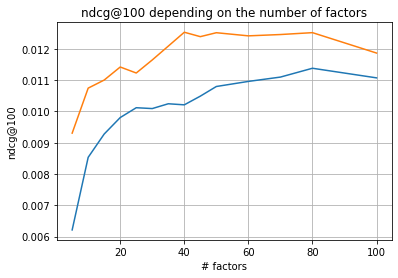

In [237]:
plt.plot(model['ib']['params']['K'], train_results_ib[f'ndcg@{N}'])
plt.plot(model['ib']['params']['K'], test_results_ib[f'ndcg@{N}'])
plt.xlabel('# factors')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of factors')
plt.grid(True)
plt.show()

In [238]:
m = CosineRecommender(K=50)
m.fit(rm_train)

final_metrics_ib = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['ib'])
final_metrics_ib

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommender


,precision,recall,map,ndcg@50,auc,mrr,f1
ib,0.000963,0.024425,0.005678,0.010232,0.000069,0.008477,0.001567


In [239]:
recs_ib = gen_recommendations(rm, rm_train, rm_test, model_name='ib', model=CosineRecommender,
                              params={'K':50}, save=True, c='', N=Nf)

  0%|          | 0/9677 [00:00<?, ?it/s]

# CosineRecommenderUB for K Neighbours

Again we must find the the number of neighbours K that maximises NDCG@100

In [240]:
model={"ub": {'m':CosineRecommenderUB,
               'params':{"K": [5,10,20, 30, 50, 100]+[i for i in range(150, 301, 50)]}}}

In [241]:
metric_results_ub, train_results_ub, test_results_ub, _  = tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N,
                                                                               model=model, check_overfitting=True)

Random Seeds [2681954887, 1596912786, 1925614583, 96153531, 3673015851]
ub5
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub10
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub20
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub30
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub50
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub100
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub150
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub200
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub250
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
ub300
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2119)

CosineRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2127)

CosineRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2110)

CosineRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2070)

CosineRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2061)

CosineRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB
Best params are ->  {'K': 300}


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB


In [242]:
train_results_ub.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
ub300,0.000526,0.003078,0.016643,0.024003,0.030936,0.001727,0.075317,0.001683,0.054390
ub250,0.000525,0.003052,0.016625,0.023974,0.030870,0.001710,0.075159,0.001706,0.055269
ub200,0.000523,0.003050,0.016562,0.023889,0.030791,0.001712,0.075159,0.001755,0.056992
ub150,0.000518,0.003007,0.016615,0.023820,0.030646,0.001694,0.074458,0.001776,0.057938
ub100,0.000496,0.002894,0.016059,0.023062,0.029785,0.001625,0.073125,0.001649,0.055379
ub50,0.000427,0.002507,0.014867,0.021076,0.027219,0.001396,0.066530,0.001835,0.067425
ub30,0.000346,0.002054,0.011819,0.017515,0.022569,0.001144,0.057018,0.001266,0.056086
ub20,0.000277,0.001701,0.009946,0.014975,0.019099,0.000949,0.048424,0.001140,0.059707
ub10,0.000178,0.001135,0.008017,0.011825,0.014370,0.000624,0.034130,0.000959,0.066761
ub5,0.000078,0.000581,0.005637,0.007948,0.009043,0.000302,0.019194,0.000952,0.105318


In [243]:
test_results_ub.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
ub300,0.002292,0.102150,0.024003,0.043093,0.000744,0.034573,0.004059
ub250,0.002256,0.101463,0.023912,0.042815,0.000739,0.034372,0.004001
ub200,0.002276,0.101070,0.023892,0.042713,0.000733,0.034157,0.004008
ub150,0.002248,0.100020,0.023743,0.042373,0.000723,0.033962,0.003955
ub100,0.002204,0.096426,0.021996,0.040232,0.000696,0.032301,0.003832
ub50,0.001839,0.085324,0.018638,0.034906,0.000570,0.028496,0.003186
ub30,0.001578,0.074260,0.016145,0.030245,0.000464,0.024449,0.002714
ub20,0.001437,0.067459,0.015769,0.028516,0.000418,0.023987,0.002442
ub10,0.001044,0.047128,0.012782,0.021460,0.000223,0.018858,0.001708
ub5,0.000699,0.028928,0.009842,0.014891,0.000104,0.014309,0.001049


In [244]:
metric_results_ub

,precision,recall,map,ndcg@100,auc,mrr,f1
ub300,0.002292,0.10215,0.024003,0.043093,0.000744,0.034573,0.004059


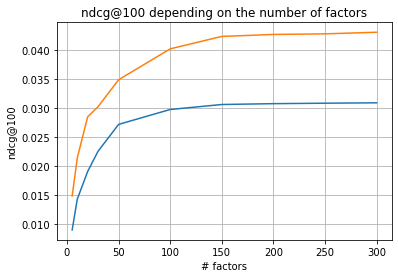

In [245]:
plt.plot(model['ub']['params']['K'], train_results_ub[f'ndcg@{N}'])
plt.plot(model['ub']['params']['K'], test_results_ub[f'ndcg@{N}'])
plt.xlabel('# factors')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of factors')
plt.grid(True)
plt.show()

### Results CosineRecommender NDCG@100
- K=200

In [246]:
m = CosineRecommenderUB(K=200)
m.fit(rm_train)

final_metrics_ub = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['ub'])
final_metrics_ub

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

CosineRecommenderUB


,precision,recall,map,ndcg@50,auc,mrr,f1
ub,0.003356,0.081385,0.023818,0.039093,0.000285,0.03418,0.005697


In [247]:
recs_ub = gen_recommendations(rm, rm_train, rm_test, model_name='ub', model=CosineRecommenderUB,
                              params={'K':200}, save=True, c='', N=Nf)

  0%|          | 0/8009 [00:00<?, ?it/s]

# Bayesian Personalized Ranking

We must optimise the number of factors

In [248]:
model={"bpr": {'m':BayesianPersonalizedRanking,
               'params':{"factors": [5]+[i for i in range(10, 101, 10)]}}}

In [249]:
metric_results_bpr, train_results_bpr, test_results_bpr, _  = tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N,
                                                                                  model=model, check_overfitting=True)

Random Seeds [928456714, 454051019, 1599065434, 3392196470, 1690993486]
bpr5
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr10
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr20
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr30
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr40
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr50
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr60
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr70
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr80
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr90
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
bpr100
Iter 1 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

BayesianPersonalizedRanking
Iter 2 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2180)

BayesianPersonalizedRanking
Iter 3 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2084)

BayesianPersonalizedRanking
Iter 4 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2172)

BayesianPersonalizedRanking
Iter 5 

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2114)

BayesianPersonalizedRanking


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking
Best params are ->  {'factors': 30}


  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking


In [250]:
train_results_bpr.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
bpr30,0.003248,0.013918,0.179706,0.206125,0.229327,0.007946,0.385688,0.187824,0.819021
bpr40,0.003205,0.013855,0.178359,0.205524,0.226990,0.007924,0.379490,0.187279,0.825055
bpr20,0.003268,0.013954,0.174979,0.199829,0.226214,0.007979,0.389014,0.179819,0.794904
bpr50,0.003136,0.013763,0.172689,0.198191,0.220929,0.007883,0.375192,0.183145,0.828975
bpr70,0.003078,0.013455,0.169502,0.194529,0.216583,0.007715,0.366424,0.180075,0.831436
bpr60,0.003072,0.013493,0.167884,0.193479,0.215728,0.007729,0.367764,0.178798,0.828812
bpr80,0.003004,0.013241,0.163617,0.188497,0.210452,0.007598,0.360121,0.175370,0.833300
bpr90,0.002940,0.013019,0.161424,0.185790,0.206997,0.007481,0.351844,0.174782,0.844367
bpr100,0.002943,0.013093,0.157394,0.181699,0.204389,0.007501,0.355645,0.173499,0.848863
bpr10,0.002900,0.011986,0.130998,0.146568,0.182778,0.006814,0.363344,0.135622,0.742008


In [251]:
test_results_bpr.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
bpr80,0.001389,0.062209,0.009911,0.021298,0.000391,0.014557,0.002437
bpr50,0.001369,0.057417,0.009604,0.020549,0.000386,0.014835,0.002412
bpr40,0.001421,0.060685,0.008713,0.020408,0.000400,0.013632,0.002510
bpr100,0.001465,0.060327,0.008331,0.020238,0.000393,0.014360,0.002574
bpr70,0.001433,0.061371,0.007984,0.020161,0.000411,0.013685,0.002537
bpr90,0.001405,0.058361,0.008370,0.019890,0.000389,0.013889,0.002451
bpr20,0.001353,0.057327,0.008776,0.019801,0.000382,0.013396,0.002371
bpr30,0.001425,0.061395,0.007865,0.019745,0.000383,0.012972,0.002521
bpr60,0.001349,0.055699,0.008603,0.019588,0.000379,0.014355,0.002376
bpr10,0.001289,0.055653,0.007165,0.017479,0.000348,0.010917,0.002174


In [252]:
metric_results_bpr

,precision,recall,map,ndcg@100,auc,mrr,f1
bpr30,0.001883,0.083438,0.011175,0.027196,0.000562,0.017329,0.003223


In [253]:
train_results_bpr[[f'ndcg@{N}']].diff(1)

,ndcg@100
bpr5,NaN
bpr10,0.079429
bpr20,0.043437
bpr30,0.003113
bpr40,-0.002337
bpr50,-0.006061
bpr60,-0.005201
bpr70,0.000855
bpr80,-0.006130
bpr90,-0.003455


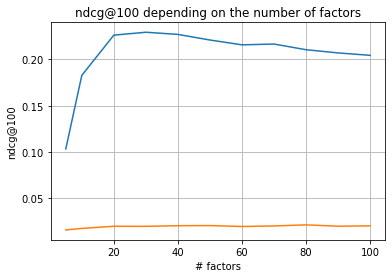

In [254]:
plt.plot(model['bpr']['params']['factors'], train_results_bpr[f'ndcg@{N}'])
plt.plot(model['bpr']['params']['factors'], test_results_bpr[f'ndcg@{N}'])
plt.xlabel('# factors')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of factors')
plt.grid(True)
plt.show()

In [255]:
m = BayesianPersonalizedRanking(factors=30)
m.fit(rm_train)

final_metrics_bpr = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['bpr'])
final_metrics_bpr

  0%|          | 0/100 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

BayesianPersonalizedRanking


,precision,recall,map,ndcg@50,auc,mrr,f1
bpr,0.002328,0.051194,0.008854,0.019554,0.000152,0.016643,0.003778


In [256]:
recs_bpr = gen_recommendations(rm, rm_train, rm_test, model_name='bpr', model=BayesianPersonalizedRanking,
                               params={'factors':30}, save=True, c='', N=Nf)

  0%|          | 0/100 [00:00<?, ?it/s]

# Content Based Recommender - Categories

In [257]:
model={"cb_cat": {'m':ContentBasedRecommender, 'params':{'prop_tag_matrix': [prop_cat['item_profiles']]}}}
metric_results_cb_cat, _,_,_ = tunning_and_metrics(rm_train, rm_test, N=N, model=model, Nf=None)
metric_results_cb_cat

IntProgress(value=0, max=2491)

ContentBasedRecommender


,precision,recall,map,ndcg@100,auc,mrr,f1
cb-cat,0.000976,0.03883,0.003407,0.011283,0.000241,0.006242,0.001703


In [325]:
model={"cb_cat": {'m':ContentBasedRecommender, 'params':{'prop_tag_matrix': [prop_cat['item_profiles']]}}}
final_metrics_cb_cat, _,_,_ = tunning_and_metrics(rm_train, rm_test, N=N, model=model, Nf=Nf)
final_metrics_cb_cat

IntProgress(value=0, max=2491)

ContentBasedRecommender


,precision,recall,map,ndcg@50,auc,mrr,f1
cb_cat,0.001236,0.024997,0.003145,0.00858,0.000076,0.005712,0.001995


In [324]:
recs_cb_cat_c = gen_recommendations(rm, rm_train, rm_test, model_name='cb_cat', 
                                     model=ContentBasedRecommender, save=True, 
                                     c='', params={'prop_tag_matrix': prop_cat['item_profiles']}, N=Nf)

# Content Based Recommender - Topics

In [260]:
metric_results_cb_top, _,_,_ = \
    tunning_and_metrics(rm_train, rm_test, N=N,
                        model={"cb_top": {'m':ContentBasedRecommender,
                                           'params':{'prop_tag_matrix': [prop_top['item_profiles']],
                                                     'tag': ['topic']}}}, Nf=None)
metric_results_cb_top

IntProgress(value=0, max=2491)

ContentBasedRecommender


,precision,recall,map,ndcg@100,auc,mrr,f1
cb-top,0.001566,0.06262,0.007689,0.020211,0.000413,0.01211,0.002736


In [326]:
final_metrics_cb_top, _,_,_ = \
    tunning_and_metrics(rm_train, rm_test, N=N,
                        model={"cb_top": {'m':ContentBasedRecommender,
                                           'params':{'prop_tag_matrix': [prop_top['item_profiles']],
                                                     'tag': ['topic']}}}, Nf=Nf)
final_metrics_cb_top

IntProgress(value=0, max=2491)

ContentBasedRecommender


,precision,recall,map,ndcg@50,auc,mrr,f1
cb_top,0.00212,0.04528,0.007086,0.016613,0.000139,0.011941,0.003527


In [327]:
recs_cb_top_c = gen_recommendations(rm, rm_train, rm_test, model_name='cb_top', 
                                    model=ContentBasedRecommender, save=True, 
                                    c='', params={'prop_tag_matrix': prop_top['item_profiles'],
                                                  'tag': 'topic'}, N=Nf)

# Content Based Recommender - Districts

In [263]:
metric_results_cb_loc, _,_,_= \
    tunning_and_metrics(rm_train, rm_test, cvk=1, N=N,
                        model={"cb_loc": {'m':ContentBasedRecommender,
                                           'params':{'prop_tag_matrix': [prop_loc['item_profiles']],
                                                     'tag': ['district']}}}, Nf=None)
metric_results_cb_loc

IntProgress(value=0, max=2491)

ContentBasedRecommender


,precision,recall,map,ndcg@100,auc,mrr,f1
cb-loc,0.000438,0.027088,0.004166,0.008647,0.00017,0.004868,0.000821


In [328]:
final_metrics_cb_loc, _,_,_= \
    tunning_and_metrics(rm_train, rm_test, cvk=1, N=N,
                        model={"cb_loc": {'m':ContentBasedRecommender,
                                           'params':{'prop_tag_matrix': [prop_loc['item_profiles']],
                                                     'tag': ['district']}}}, Nf=Nf)
final_metrics_cb_loc

IntProgress(value=0, max=2491)

ContentBasedRecommender


,precision,recall,map,ndcg@50,auc,mrr,f1
cb_loc,0.000498,0.016322,0.003785,0.006525,0.000052,0.004503,0.000926


In [329]:
recs_cb_loc = gen_recommendations(rm, rm_train, rm_test, model_name='cb_loc',
                                     model=ContentBasedRecommender, save=True, 
                                     c='', params={'prop_tag_matrix': prop_loc['item_profiles'],
                                                     'tag': 'district'}, N=Nf)

# Hybrid User Based - Categories

In [266]:
model={"cbub_cat": {"m":HybridRecommenderUB,
                     "params":{"prop_tag_matrix": [prop_cat['item_profiles']],
                              "tag": ['category'],
                              "K": [5]+[k for k in range(50, 401, 50)] + [1000, 2000, 6000]}}}

In [267]:
metric_results_cbub_cat, train_results_cbub_cat, test_results_cbub_cat, _  = tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N,
                                                                                                    model=model, check_overfitting=True)

Random Seeds [1383822288, 3528575306, 4020598145, 493611805, 2190345833]
cbub-cat5
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat50
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat100
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat150
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat200
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat250
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat300
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat350
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat400
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat1000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat2000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-cat6000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2093)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2118)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2136)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
Best params are ->  {'K': 6000, 'prop_tag_matrix': <9677x30 sparse matrix of type '<class 'numpy.float64'>'
	with 20277 stored elements in Compressed Sparse Row format>, 'tag': 'category'}


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB


In [268]:
train_results_cbub_cat.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
cbub-cat6000,0.000614,0.003281,0.015047,0.024292,0.032003,0.001786,0.088200,0.002285,0.071409
cbub-cat2000,0.000567,0.003028,0.013347,0.022237,0.029026,0.001653,0.080823,0.001048,0.036117
cbub-cat1000,0.000502,0.002714,0.012194,0.020399,0.026042,0.001493,0.070932,0.000533,0.020466
cbub-cat400,0.000441,0.002511,0.011244,0.018646,0.023517,0.001395,0.063167,0.000776,0.033016
cbub-cat300,0.000429,0.002526,0.010969,0.018306,0.023165,0.001403,0.062968,0.001018,0.043963
cbub-cat350,0.000435,0.002486,0.011017,0.018281,0.023082,0.001382,0.061840,0.000653,0.028280
cbub-cat250,0.000422,0.002482,0.010570,0.017558,0.022583,0.001373,0.061868,0.000873,0.038646
cbub-cat200,0.000385,0.002407,0.010067,0.016800,0.021672,0.001331,0.059877,0.001312,0.060516
cbub-cat150,0.000343,0.002317,0.010148,0.016166,0.021194,0.001286,0.057996,0.000895,0.042222
cbub-cat100,0.000311,0.002340,0.009351,0.014813,0.020308,0.001304,0.057579,0.001294,0.063736


In [269]:
test_results_cbub_cat.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
cbub-cat6000,0.002023,0.105196,0.020483,0.040212,0.000791,0.030978,0.003717
cbub-cat2000,0.001863,0.097393,0.018911,0.037210,0.000730,0.028770,0.003427
cbub-cat1000,0.001650,0.083038,0.016607,0.032202,0.000613,0.025092,0.003002
cbub-cat300,0.001666,0.077409,0.015847,0.030330,0.000552,0.023997,0.003010
cbub-cat400,0.001626,0.076532,0.015713,0.030053,0.000552,0.024031,0.002933
cbub-cat350,0.001650,0.076560,0.015544,0.029924,0.000549,0.023735,0.002972
cbub-cat250,0.001678,0.076964,0.014887,0.029287,0.000538,0.022372,0.003026
cbub-cat200,0.001682,0.074875,0.014287,0.028337,0.000478,0.021594,0.003027
cbub-cat150,0.001682,0.074839,0.013289,0.027356,0.000436,0.020818,0.003021
cbub-cat100,0.001618,0.070052,0.011025,0.024528,0.000394,0.018340,0.002880


In [270]:
metric_results_cbub_cat

,precision,recall,map,ndcg@100,auc,mrr,f1
cbub-cat6000,0.002023,0.105196,0.020483,0.040212,0.000791,0.030978,0.003717


In [271]:
train_results_cbub_cat[[f'ndcg@{N}']].diff(1)

,ndcg@100
cbub-cat5,NaN
cbub-cat50,0.010043
cbub-cat100,0.003617
cbub-cat150,0.000886
cbub-cat200,0.000478
cbub-cat250,0.000910
cbub-cat300,0.000582
cbub-cat350,-0.000083
cbub-cat400,0.000435
cbub-cat1000,0.002524


In [272]:
train_results_cbub_cat[[f'ndcg@{N}']].diff(1)

,ndcg@100
cbub-cat5,NaN
cbub-cat50,0.010043
cbub-cat100,0.003617
cbub-cat150,0.000886
cbub-cat200,0.000478
cbub-cat250,0.000910
cbub-cat300,0.000582
cbub-cat350,-0.000083
cbub-cat400,0.000435
cbub-cat1000,0.002524


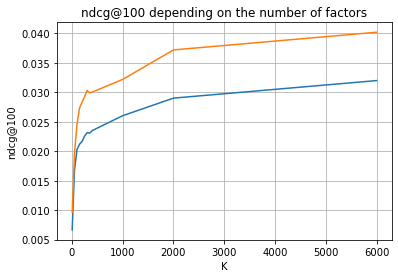

In [273]:
plt.plot(model['cbub_cat']['params']['K'], train_results_cbub_cat[f'ndcg@{N}'])
plt.plot(model['cbub_cat']['params']['K'], test_results_cbub_cat[f'ndcg@{N}'])
plt.xlabel('K')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of factors')
plt.grid(True)
plt.show()

In [274]:
m = HybridRecommenderUB(K=2000, prop_tag_matrix=prop_cat['item_profiles'], tag='category')
m.fit(rm_train)

final_metrics_cbub_cat = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                    index=['cbub_cat'])
final_metrics_cbub_cat

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB


,precision,recall,map,ndcg@50,auc,mrr,f1
cbub_cat,0.002931,0.078275,0.018628,0.033758,0.000275,0.028431,0.005191


In [275]:
recs_cbub_cat = gen_recommendations(rm, rm_train, rm_test, model_name='cbub_cat', 
                                    model=HybridRecommenderUB, save=True, 
                                    c='', params={'prop_tag_matrix': prop_cat['item_profiles'],
                                                  'tag': 'category',
                                                  'K':2000}, N=Nf)

  0%|          | 0/8009 [00:00<?, ?it/s]

# Hybrid User Based - Topics

In [276]:
model={"cbub_top": {"m":HybridRecommenderUB,
                    "params":{"prop_tag_matrix": [prop_top['item_profiles']],
                              "tag": ['topic'],
                              "K": [5]+[k for k in range(50, 401, 50)] + [1000, 2000, 6000]}}}

In [277]:
metric_results_cbub_top, train_results_cbub_top, test_results_cbub_top, _  = \
    tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=model, check_overfitting=True)

Random Seeds [3861307869, 3471205154, 3596151562, 1761577280, 4175628871]
cbub-top5
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top50
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top100
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top150
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top200
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top250
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top300
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top350
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top400
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top1000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top2000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-top6000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2077)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2124)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2090)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2057)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
Best params are ->  {'K': 6000, 'prop_tag_matrix': <9677x320 sparse matrix of type '<class 'numpy.float64'>'
	with 23521 stored elements in Compressed Sparse Row format>, 'tag': 'topic'}


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB


In [278]:
train_results_cbub_top.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
cbub-top6000,0.000669,0.003430,0.018524,0.028428,0.036175,0.001866,0.095027,0.001263,0.034914
cbub-top2000,0.000652,0.003302,0.018088,0.027450,0.035066,0.001794,0.091592,0.000881,0.025128
cbub-top1000,0.000622,0.003252,0.016918,0.025561,0.033240,0.001776,0.086819,0.001502,0.045178
cbub-top400,0.000602,0.003240,0.016545,0.025448,0.032459,0.001779,0.084074,0.001444,0.044489
cbub-top350,0.000598,0.003204,0.016579,0.025324,0.032237,0.001762,0.082893,0.001371,0.042515
cbub-top200,0.000570,0.003242,0.016255,0.024691,0.031816,0.001785,0.082951,0.001450,0.045567
cbub-top300,0.000586,0.003207,0.016175,0.024809,0.031765,0.001767,0.082514,0.001548,0.048718
cbub-top250,0.000577,0.003202,0.015924,0.024447,0.031363,0.001766,0.081350,0.001424,0.045407
cbub-top150,0.000528,0.003218,0.015816,0.023891,0.031304,0.001764,0.082888,0.001802,0.057573
cbub-top100,0.000502,0.003200,0.015438,0.023404,0.030753,0.001753,0.082374,0.001692,0.055027


In [279]:
test_results_cbub_top.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
cbub-top6000,0.002084,0.105598,0.023300,0.042450,0.000766,0.034359,0.003796
cbub-top2000,0.002055,0.101334,0.022025,0.040545,0.000747,0.031560,0.003700
cbub-top1000,0.002011,0.096616,0.021491,0.039136,0.000723,0.030245,0.003587
cbub-top400,0.002027,0.093210,0.019205,0.036649,0.000675,0.028103,0.003636
cbub-top350,0.002084,0.093167,0.019058,0.036578,0.000677,0.028037,0.003702
cbub-top250,0.002071,0.092510,0.018994,0.036269,0.000665,0.027988,0.003689
cbub-top200,0.002092,0.093370,0.019104,0.036250,0.000637,0.027317,0.003741
cbub-top150,0.002100,0.094357,0.018868,0.036198,0.000610,0.027465,0.003757
cbub-top300,0.002079,0.093749,0.018177,0.035815,0.000671,0.026635,0.003689
cbub-top100,0.001995,0.089603,0.017837,0.034433,0.000551,0.026134,0.003573


In [280]:
metric_results_cbub_top

,precision,recall,map,ndcg@100,auc,mrr,f1
cbub-top6000,0.002084,0.105598,0.0233,0.04245,0.000766,0.034359,0.003796


In [281]:
train_results_cbub_top[[f'ndcg@{N}']].diff(1)

,ndcg@100
cbub-top5,NaN
cbub-top50,0.015326
cbub-top100,0.003400
cbub-top150,0.000552
cbub-top200,0.000511
cbub-top250,-0.000453
cbub-top300,0.000402
cbub-top350,0.000472
cbub-top400,0.000223
cbub-top1000,0.000781


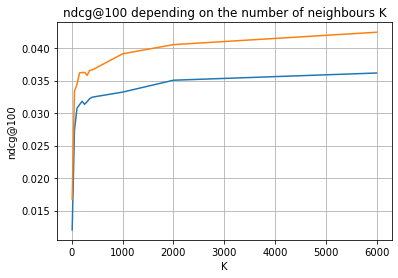

In [282]:
plt.plot(model['cbub_top']['params']['K'], train_results_cbub_top[f'ndcg@{N}'])
plt.plot(model['cbub_top']['params']['K'], test_results_cbub_top[f'ndcg@{N}'])
plt.xlabel('K')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of neighbours K')
plt.grid(True)
plt.show()

In [283]:
m = HybridRecommenderUB(K=2000, prop_tag_matrix=prop_top['item_profiles'], tag='topic')
m.fit(rm_train)

final_metrics_cbub_top = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['cbub_top'])
final_metrics_cbub_top

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB


,precision,recall,map,ndcg@50,auc,mrr,f1
cbub_top,0.002874,0.076446,0.021616,0.035837,0.000282,0.031098,0.005014


In [284]:
recs_cbub_top = gen_recommendations(rm, rm_train, rm_test, model_name='cbub_top', 
                                       model=HybridRecommenderUB, save=True, 
                                       c='', params={'prop_tag_matrix': prop_top['item_profiles'],
                                                       'tag': 'topic',
                                                       'K':2000}, N=Nf)

  0%|          | 0/8009 [00:00<?, ?it/s]

# Hybrid User Based - Locations

In [285]:
model={"cbub_loc": {"m":HybridRecommenderUB,
                    "params":{"prop_tag_matrix": [prop_loc['item_profiles']],
                              "tag": ['district'],
                              "K": [100, 150, 200, 500, 1000, 1500, 2000, 4000, 6000, 7000]}}}

In [286]:
metric_results_cbub_loc, train_results_cbub_loc, test_results_cbub_loc, _  = \
    tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=model, check_overfitting=True)

Random Seeds [3309305640, 3840260271, 112109253, 3068048813, 525778758]
cbub-loc100
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc150
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc200
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc500
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc1000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc1500
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc2000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc4000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc6000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
cbub-loc7000
Iter 1 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderUB
Iter 2 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2087)

HybridRecommenderUB
Iter 3 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2115)

HybridRecommenderUB
Iter 4 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2135)

HybridRecommenderUB
Iter 5 

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2092)

HybridRecommenderUB


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB
Best params are ->  {'K': 6000, 'prop_tag_matrix': <9677x22 sparse matrix of type '<class 'numpy.float64'>'
	with 14803 stored elements in Compressed Sparse Row format>, 'tag': 'district'}


  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB


In [287]:
train_results_cbub_loc.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
cbub-loc6000,0.000587,0.002741,0.012729,0.018714,0.028259,0.001479,0.082838,0.003448,0.122006
cbub-loc7000,0.000587,0.002741,0.012729,0.018714,0.028259,0.001479,0.082838,0.003448,0.122006
cbub-loc4000,0.000554,0.002511,0.012267,0.018229,0.026770,0.001353,0.077071,0.003401,0.127050
cbub-loc2000,0.000452,0.001999,0.011060,0.016427,0.022650,0.001072,0.062356,0.003007,0.132756
cbub-loc1500,0.000431,0.001873,0.011577,0.017108,0.022332,0.001006,0.058017,0.002860,0.128083
cbub-loc1000,0.000405,0.001797,0.010936,0.016180,0.021089,0.000964,0.055620,0.002433,0.115370
cbub-loc500,0.000382,0.001774,0.010277,0.015036,0.020129,0.000957,0.055628,0.002517,0.125036
cbub-loc150,0.000371,0.001890,0.009929,0.014479,0.019910,0.001042,0.054671,0.001878,0.094309
cbub-loc100,0.000323,0.001924,0.009272,0.013854,0.019349,0.001060,0.055069,0.002299,0.118803
cbub-loc200,0.000368,0.001801,0.009539,0.014040,0.019254,0.000988,0.053509,0.002109,0.109523


In [288]:
test_results_cbub_loc.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
cbub-loc7000,0.001766,0.103306,0.017264,0.036009,0.000721,0.025662,0.003304
cbub-loc6000,0.001658,0.096335,0.017113,0.034678,0.000694,0.025499,0.003099
cbub-loc4000,0.001437,0.082817,0.015474,0.030933,0.000610,0.023782,0.002685
cbub-loc1500,0.001224,0.072923,0.015394,0.028473,0.000520,0.023432,0.002298
cbub-loc2000,0.001228,0.071793,0.015036,0.028065,0.000530,0.022883,0.002291
cbub-loc1000,0.001224,0.073342,0.013940,0.026977,0.000512,0.021095,0.002286
cbub-loc500,0.001265,0.073491,0.013410,0.026410,0.000504,0.020762,0.002313
cbub-loc200,0.001212,0.066532,0.012844,0.024838,0.000473,0.019887,0.002191
cbub-loc100,0.001156,0.062842,0.011738,0.023295,0.000402,0.017978,0.002101
cbub-loc150,0.001176,0.063146,0.011425,0.023185,0.000441,0.018260,0.002122


In [289]:
metric_results_cbub_loc

,precision,recall,map,ndcg@100,auc,mrr,f1
cbub-loc6000,0.001658,0.096335,0.017113,0.034678,0.000694,0.025499,0.003099


In [290]:
train_results_cbub_loc[[f'ndcg@{N}']].diff(1)

,ndcg@100
cbub-loc100,NaN
cbub-loc150,0.000560
cbub-loc200,-0.000656
cbub-loc500,0.000876
cbub-loc1000,0.000960
cbub-loc1500,0.001242
cbub-loc2000,0.000319
cbub-loc4000,0.004120
cbub-loc6000,0.001489
cbub-loc7000,0.000000


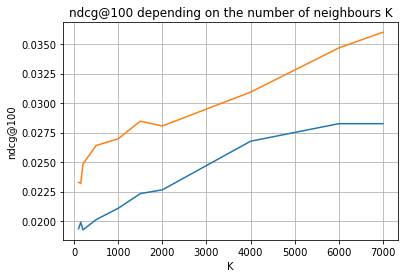

In [291]:
plt.plot(model['cbub_loc']['params']['K'], train_results_cbub_loc[f'ndcg@{N}'])
plt.plot(model['cbub_loc']['params']['K'], test_results_cbub_loc[f'ndcg@{N}'])
plt.xlabel('K')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of neighbours K')
plt.grid(True)
plt.show()

In [292]:
m = HybridRecommenderUB(K=6000, prop_tag_matrix=prop_loc['item_profiles'], tag='district')
m.fit(rm_train)

final_metrics_cbub_loc = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                    index=['cbub_loc'])
final_metrics_cbub_loc

  0%|          | 0/8009 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderUB


,precision,recall,map,ndcg@50,auc,mrr,f1
cbub_loc,0.002409,0.071656,0.016725,0.030191,0.00025,0.025018,0.004348


In [293]:
recs_cbub_loc = gen_recommendations(rm, rm_train, rm_test, model_name='cbub_loc', 
                                    model=HybridRecommenderUB, save=True, 
                                    c='', params={'prop_tag_matrix': prop_loc['item_profiles'],
                                                  'tag': 'district',
                                                  'K':6000})

  0%|          | 0/8009 [00:00<?, ?it/s]

# Hybrid Item Based - Categories

In [294]:
model={"cbib_cat": {"m":HybridRecommenderIB,
                     "params":{"prop_tag_matrix": [prop_cat['item_profiles']],
                              "tag": ['category'],
                              "K": [5, 10, 30, 50, 70, 100, 120, 150, 200]}}}

In [295]:
metric_results_cbib_cat, train_results_cbib_cat, test_results_cbib_cat, _  = \
    tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=model, check_overfitting=True)

Random Seeds [3110333049, 531457177, 2468921130, 3933561247, 3721807368]
cbib-cat5
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat10
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat30
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat50
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat70
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat100
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat120
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat150
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-cat200
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2042)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2085)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2010)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2128)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2081)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
Best params are ->  {'K': 100, 'prop_tag_matrix': <9677x30 sparse matrix of type '<class 'numpy.float64'>'
	with 20277 stored elements in Compressed Sparse Row format>, 'tag': 'category'}


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB


In [296]:
train_results_cbib_cat.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
cbib-cat100,0.000180,0.001231,0.002802,0.004684,0.008801,0.000680,0.030730,0.001112,0.126343
cbib-cat200,0.000187,0.001214,0.002642,0.004561,0.008759,0.000666,0.031087,0.001001,0.114337
cbib-cat120,0.000178,0.001229,0.002695,0.004456,0.008686,0.000676,0.030967,0.000923,0.106294
cbib-cat150,0.000183,0.001220,0.002356,0.004068,0.008498,0.000670,0.031328,0.000932,0.109654
cbib-cat70,0.000149,0.001180,0.002427,0.003870,0.008007,0.000664,0.028666,0.000929,0.115977
cbib-cat30,0.000100,0.001108,0.002910,0.004071,0.007791,0.000639,0.024803,0.000559,0.071780
cbib-cat50,0.000127,0.001094,0.002497,0.003476,0.007515,0.000629,0.025743,0.000884,0.117613
cbib-cat10,0.000031,0.000662,0.001440,0.002344,0.003863,0.000407,0.010872,0.000581,0.150447
cbib-cat5,0.000014,0.000470,0.001015,0.001567,0.002574,0.000293,0.006665,0.000414,0.160903


In [297]:
test_results_cbib_cat.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
cbib-cat120,0.000815,0.033702,0.003503,0.010359,0.000206,0.007010,0.001476
cbib-cat150,0.000823,0.033517,0.003407,0.010204,0.000201,0.006591,0.001484
cbib-cat200,0.000819,0.034868,0.003142,0.010133,0.000212,0.005876,0.001481
cbib-cat100,0.000811,0.033550,0.003221,0.010050,0.000201,0.006760,0.001466
cbib-cat70,0.000751,0.031775,0.003116,0.009441,0.000171,0.005394,0.001347
cbib-cat50,0.000703,0.028056,0.003087,0.008724,0.000145,0.004746,0.001212
cbib-cat30,0.000715,0.027201,0.002867,0.008381,0.000105,0.004409,0.001241
cbib-cat10,0.000526,0.016038,0.002271,0.005737,0.000045,0.003558,0.000883
cbib-cat5,0.000405,0.010013,0.001452,0.003857,0.000021,0.002747,0.000677


In [298]:
metric_results_cbib_cat

,precision,recall,map,ndcg@100,auc,mrr,f1
cbib-cat100,0.000811,0.03355,0.003221,0.01005,0.000201,0.00676,0.001466


In [299]:
train_results_cbib_cat[[f'ndcg@{N}']].diff(1)

,ndcg@100
cbib-cat5,NaN
cbib-cat10,0.001289
cbib-cat30,0.003928
cbib-cat50,-0.000276
cbib-cat70,0.000491
cbib-cat100,0.000794
cbib-cat120,-0.000116
cbib-cat150,-0.000187
cbib-cat200,0.000260


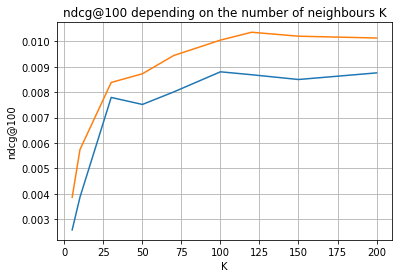

In [300]:
plt.plot(model['cbib_cat']['params']['K'], train_results_cbib_cat[f'ndcg@{N}'])
plt.plot(model['cbib_cat']['params']['K'], test_results_cbib_cat[f'ndcg@{N}'])
plt.xlabel('K')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of neighbours K')
plt.grid(True)
plt.show()

In [301]:
m = HybridRecommenderIB(K=100, prop_tag_matrix=prop_cat['item_profiles'], tag='category')
m.fit(rm_train)

final_metrics_cbib_cat = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['cbib_cat'])
final_metrics_cbib_cat

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB


,precision,recall,map,ndcg@50,auc,mrr,f1
cbib_cat,0.000996,0.021029,0.002717,0.007327,0.000063,0.006049,0.001709


In [302]:
recs_cbib_cat = gen_recommendations(rm, rm_train, rm_test, model_name='cbib_cat', 
                                    model=HybridRecommenderIB, save=True, 
                                    c='', params={'prop_tag_matrix': prop_cat['item_profiles'],
                                                  'tag': 'category',
                                                  'K':100}, N=Nf)

  0%|          | 0/9677 [00:00<?, ?it/s]

# Hybrid Item Based - Topics

In [303]:
model={"cbib_top": {"m":HybridRecommenderIB,
                     "params":{"prop_tag_matrix": [prop_top['item_profiles']],
                               "tag": ['topic'],
                               "K": [5]+[i for i in range(10, 301, 50)]}}}

In [304]:
metric_results_cbib_top, train_results_cbib_top, test_results_cbib_top, _  = \
    tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=model, check_overfitting=True)

Random Seeds [1246927591, 274439948, 3498800219, 3673592989, 1289859121]
cbib-top5
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2063)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2041)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2156)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-top10
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2063)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2041)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2156)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-top60
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2063)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2041)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2156)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-top110
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2063)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2041)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2156)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-top160
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2063)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2041)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2156)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-top210
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2063)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2041)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2156)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-top260
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2062)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2063)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2041)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2156)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2079)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
Best params are ->  {'K': 210, 'prop_tag_matrix': <9677x320 sparse matrix of type '<class 'numpy.float64'>'
	with 23521 stored elements in Compressed Sparse Row format>, 'tag': 'topic'}


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB


In [305]:
train_results_cbib_top.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
cbib-top210,0.000332,0.002304,0.007240,0.010848,0.017797,0.001298,0.054234,0.000775,0.043560
cbib-top160,0.000329,0.002280,0.007379,0.011035,0.017731,0.001289,0.053339,0.000925,0.052192
cbib-top260,0.000328,0.002299,0.007172,0.010903,0.017725,0.001297,0.054452,0.000540,0.030472
cbib-top110,0.000326,0.002350,0.007119,0.010934,0.017689,0.001332,0.054147,0.001170,0.066153
cbib-top60,0.000269,0.002216,0.007422,0.010954,0.017238,0.001248,0.050036,0.001086,0.062983
cbib-top10,0.000071,0.001376,0.005236,0.008281,0.010407,0.000813,0.023759,0.001005,0.096561
cbib-top5,0.000038,0.001080,0.003857,0.006431,0.007611,0.000656,0.015962,0.001144,0.150247


In [306]:
test_results_cbib_top.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
cbib-top260,0.001441,0.055136,0.008319,0.019253,0.000345,0.013052,0.002538
cbib-top160,0.001449,0.055848,0.008178,0.019147,0.000345,0.013114,0.002554
cbib-top210,0.001453,0.054609,0.008341,0.019045,0.000337,0.013026,0.002551
cbib-top110,0.001469,0.054873,0.007185,0.018292,0.000344,0.011931,0.002589
cbib-top60,0.001341,0.050132,0.008174,0.018143,0.000264,0.013426,0.002335
cbib-top10,0.000996,0.028184,0.006297,0.012691,0.000088,0.011583,0.001688
cbib-top5,0.000771,0.017819,0.004546,0.008776,0.000041,0.007912,0.001246


In [307]:
metric_results_cbib_top

,precision,recall,map,ndcg@100,auc,mrr,f1
cbib-top210,0.001453,0.054609,0.008341,0.019045,0.000337,0.013026,0.002551


In [308]:
train_results_cbib_top[[f'ndcg@{N}']].diff(1)

,ndcg@100
cbib-top5,NaN
cbib-top10,0.002796
cbib-top60,0.006831
cbib-top110,0.000451
cbib-top160,0.000043
cbib-top210,0.000066
cbib-top260,-0.000072


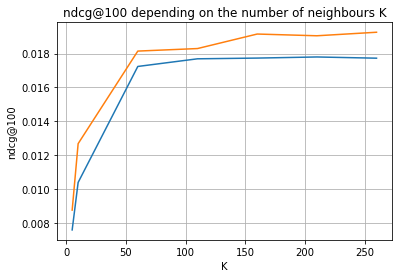

In [309]:
plt.plot(model['cbib_top']['params']['K'], train_results_cbib_top[f'ndcg@{N}'])
plt.plot(model['cbib_top']['params']['K'], test_results_cbib_top[f'ndcg@{N}'])
plt.xlabel('K')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of neighbours K')
plt.grid(True)
plt.show()

In [310]:
m = HybridRecommenderIB(K=100, prop_tag_matrix=prop_top['item_profiles'], tag='topic')
m.fit(rm_train)
final_metrics_cbib_top = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['cbib_top'])
final_metrics_cbib_top

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB


,precision,recall,map,ndcg@50,auc,mrr,f1
cbib_top,0.001863,0.036609,0.00705,0.014808,0.000112,0.012072,0.003089


In [311]:
recs_cbib_top = gen_recommendations(rm, rm_train, rm_test, model_name='cbib_top', 
                                    model=HybridRecommenderIB, save=True, 
                                    c='', params={'prop_tag_matrix': prop_top['item_profiles'],
                                                  'tag': 'topic',
                                                  'K':100})

  0%|          | 0/9677 [00:00<?, ?it/s]

# Hybrid Item Based - Locations

In [312]:
model={"cbib_loc": {"m":HybridRecommenderIB,
                     "params":{"prop_tag_matrix": [prop_loc['item_profiles']],
                               "tag": ['district'],
                               "K": [5]+[i for i in range(10, 101, 10)]}}}

In [313]:
metric_results_cbib_loc, train_results_cbib_loc, test_results_cbib_loc, _  = \
    tunning_and_metrics(rm_train, rm_test, cvk=cvk, N=N, model=model, check_overfitting=True)

Random Seeds [3872397645, 3466950978, 3596791613, 1492844510, 1028572424]
cbib-loc5
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc10
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc20
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc30
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc40
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc50
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc60
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc70
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc80
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc90
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
cbib-loc100
Iter 1 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2080)

HybridRecommenderIB
Iter 2 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2111)

HybridRecommenderIB
Iter 3 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2086)

HybridRecommenderIB
Iter 4 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2064)

HybridRecommenderIB
Iter 5 

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2075)

HybridRecommenderIB


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB
Best params are ->  {'K': 70, 'prop_tag_matrix': <9677x22 sparse matrix of type '<class 'numpy.float64'>'
	with 14803 stored elements in Compressed Sparse Row format>, 'tag': 'district'}


  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB


In [314]:
train_results_cbib_loc.sort_values(by=f'ndcg@{N}', ascending=False)

,auc,f1,map,mrr,ndcg@100,precision,recall,std_ndcg@100,var_coef_ndcg@100
cbib-loc70,0.000099,0.000811,0.002399,0.002984,0.006325,0.000479,0.022004,0.001065,0.168408
cbib-loc60,0.000093,0.000882,0.001898,0.002386,0.006149,0.000521,0.023260,0.000838,0.136306
cbib-loc80,0.000112,0.000770,0.002197,0.002817,0.006148,0.000453,0.021401,0.000632,0.102769
cbib-loc100,0.000137,0.000703,0.002182,0.002607,0.006050,0.000405,0.021316,0.000960,0.158687
cbib-loc90,0.000128,0.000730,0.001928,0.002525,0.005902,0.000424,0.021030,0.000912,0.154463
cbib-loc50,0.000083,0.000901,0.001660,0.002324,0.005898,0.000539,0.022871,0.000633,0.107300
cbib-loc40,0.000072,0.000836,0.001989,0.002712,0.005833,0.000510,0.020320,0.000671,0.115007
cbib-loc30,0.000051,0.000721,0.001863,0.002627,0.005087,0.000445,0.016647,0.000653,0.128425
cbib-loc20,0.000033,0.000578,0.001720,0.002286,0.004290,0.000366,0.012772,0.000653,0.152338
cbib-loc10,0.000013,0.000427,0.001943,0.002613,0.003501,0.000284,0.007543,0.000950,0.271291


In [315]:
test_results_cbib_loc.sort_values(by=f'ndcg@{N}', ascending=False)

,precision,recall,map,ndcg@100,auc,mrr,f1
cbib-loc70,0.000574,0.025266,0.003858,0.008114,0.000113,0.004312,0.000930
cbib-loc60,0.000590,0.025671,0.003282,0.007798,0.000110,0.003631,0.000960
cbib-loc100,0.000426,0.024157,0.002888,0.007024,0.000144,0.003262,0.000752
cbib-loc50,0.000650,0.025732,0.002179,0.006915,0.000087,0.003724,0.001036
cbib-loc90,0.000462,0.023986,0.002541,0.006711,0.000125,0.003056,0.000779
cbib-loc80,0.000498,0.022349,0.002441,0.006508,0.000116,0.002936,0.000805
cbib-loc40,0.000558,0.022190,0.002168,0.006227,0.000069,0.002615,0.000885
cbib-loc30,0.000494,0.018217,0.002241,0.005674,0.000061,0.002873,0.000754
cbib-loc20,0.000434,0.014289,0.002014,0.004873,0.000038,0.003179,0.000648
cbib-loc10,0.000317,0.008410,0.002386,0.004018,0.000015,0.003283,0.000468


In [316]:
metric_results_cbib_loc

,precision,recall,map,ndcg@100,auc,mrr,f1
cbib-loc70,0.000574,0.025266,0.003858,0.008114,0.000113,0.004312,0.00093


In [317]:
train_results_cbib_loc[[f'ndcg@{N}']].diff(1)

,ndcg@100
cbib-loc5,NaN
cbib-loc10,0.000905
cbib-loc20,0.000789
cbib-loc30,0.000797
cbib-loc40,0.000746
cbib-loc50,0.000065
cbib-loc60,0.000251
cbib-loc70,0.000177
cbib-loc80,-0.000177
cbib-loc90,-0.000246


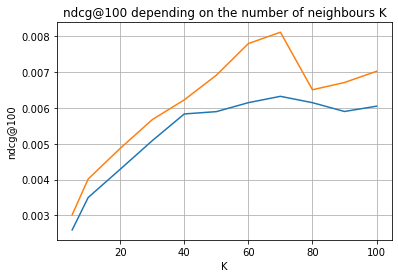

In [318]:
plt.plot(model['cbib_loc']['params']['K'], train_results_cbib_loc[f'ndcg@{N}'])
plt.plot(model['cbib_loc']['params']['K'], test_results_cbib_loc[f'ndcg@{N}'])
plt.xlabel('K')
plt.ylabel(f'ndcg@{N}')
plt.title(f'ndcg@{N} depending on the number of neighbours K')
plt.grid(True)
plt.show()

In [319]:
m = HybridRecommenderIB(K=70, prop_tag_matrix=prop_loc['item_profiles'], tag='topic')
m.fit(rm_train)

final_metrics_cbib_loc = pd.DataFrame(data=ranking_metrics_at_k(m, rm_train, rm_test, K=Nf).mean().to_dict(),
                                         index=['cbib_loc'])
final_metrics_cbib_loc

  0%|          | 0/9677 [00:00<?, ?it/s]

IntProgress(value=0, max=2491)

HybridRecommenderIB


,precision,recall,map,ndcg@50,auc,mrr,f1
cbib_loc,0.000418,0.013317,0.002055,0.004507,0.000042,0.002439,0.000734


In [320]:
recs_cbib_loc = gen_recommendations(rm, rm_train, rm_test, model_name='cbib_loc', 
                                    model=HybridRecommenderIB, save=True, 
                                    c='', params={'prop_tag_matrix': prop_loc['item_profiles'],
                                                  'tag': 'district','K':70})

  0%|          | 0/9677 [00:00<?, ?it/s]

In [348]:
final_metrics = pd.concat([final_metrics_rand, final_metrics_pop, final_metrics_pop_nc,
                           final_metrics_ib, final_metrics_ub, final_metrics_mf, final_metrics_bpr,
                           final_metrics_cb_cat, final_metrics_cb_top, final_metrics_cb_loc,
                           final_metrics_cbib_cat, final_metrics_cbib_top, final_metrics_cbib_loc,
                           final_metrics_cbub_cat, final_metrics_cbub_top, final_metrics_cbub_loc])

In [349]:
final_metrics

,precision,recall,map,ndcg@50,auc,mrr,f1
rand,0.000233,0.004252,0.000585,0.001448,0.000010,0.000904,0.000354
pop,0.004279,0.154419,0.032830,0.059993,0.000533,0.041846,0.007931
pop_nc,0.003950,0.142797,0.021988,0.048868,0.000491,0.028280,0.007340
ib,0.000963,0.024425,0.005678,0.010232,0.000069,0.008477,0.001567
ub,0.003356,0.081385,0.023818,0.039093,0.000285,0.034180,0.005697
mf,0.003661,0.135062,0.026034,0.050099,0.000447,0.032346,0.006785
bpr,0.002328,0.051194,0.008854,0.019554,0.000152,0.016643,0.003778
cb_cat,0.001236,0.024997,0.003145,0.008580,0.000076,0.005712,0.001995
cb_top,0.002120,0.045280,0.007086,0.016613,0.000139,0.011941,0.003527
cb_loc,0.000498,0.016322,0.003785,0.006525,0.000052,0.004503,0.000926


In [350]:
final_metrics = final_metrics.rename(columns={'precision':'Precision', 'recall':'Recall', 'map':'MAP',
                                              f'ndcg@{Nf}':'nDCG', 'mrr':'MRR', 'f1':'F1'})
final_metrics.drop(columns=['auc'], inplace=True)
final_metrics = final_metrics.loc[[s for s in MODEL_ORDER.keys()]]

In [351]:
final_metrics

,Precision,Recall,MAP,nDCG,MRR,F1
rand,0.000233,0.004252,0.000585,0.001448,0.000904,0.000354
pop,0.004279,0.154419,0.032830,0.059993,0.041846,0.007931
pop_nc,0.003950,0.142797,0.021988,0.048868,0.028280,0.007340
ib,0.000963,0.024425,0.005678,0.010232,0.008477,0.001567
ub,0.003356,0.081385,0.023818,0.039093,0.034180,0.005697
mf,0.003661,0.135062,0.026034,0.050099,0.032346,0.006785
bpr,0.002328,0.051194,0.008854,0.019554,0.016643,0.003778
cb_cat,0.001236,0.024997,0.003145,0.008580,0.005712,0.001995
cb_top,0.002120,0.045280,0.007086,0.016613,0.011941,0.003527
cb_loc,0.000498,0.016322,0.003785,0.006525,0.004503,0.000926


In [352]:
final_metrics.to_csv(f'../../data/result_metrics/ranking_{Nf}.csv')

In [353]:
final_metrics_styled = final_metrics.style.background_gradient().format('{:.3f}')
final_metrics_styled

,Precision,Recall,MAP,nDCG,MRR,F1
rand,0.000,0.004,0.001,0.001,0.001,0.000
pop,0.004,0.154,0.033,0.060,0.042,0.008
pop_nc,0.004,0.143,0.022,0.049,0.028,0.007
ib,0.001,0.024,0.006,0.010,0.008,0.002
ub,0.003,0.081,0.024,0.039,0.034,0.006
mf,0.004,0.135,0.026,0.050,0.032,0.007
bpr,0.002,0.051,0.009,0.020,0.017,0.004
cb_cat,0.001,0.025,0.003,0.009,0.006,0.002
cb_top,0.002,0.045,0.007,0.017,0.012,0.004
cb_loc,0.000,0.016,0.004,0.007,0.005,0.001
